In [1]:
import numpy as np
import xarray as xr
import cedalion.data
import cedalion.vis
import matplotlib.pyplot as p
import pickle
import os
import pandas as pd
# import cedalion_parcellation
# import cedalion_parcellation.data
# import cedalion_parcellation.vis
# import cedalion.imagereco.forward_model as fw
import cedalion.dot.forward_model as fw
# from cedalion.imagereco.solver import pseudo_inverse_stacked
import cedalion.geometry.landmarks as cd_landmarks
import pyvista as pv
import cedalion.dataclasses as cdc
pv.set_jupyter_backend('server')
import warnings
warnings.filterwarnings("ignore")

# from src.subset import configs

In [2]:
# path_prefix = 'src/subset/'
DATASET_NAME = 'BallSqueezingHD_modified'
data_path_prefix = f'datasets/raw/{DATASET_NAME}/'
results_path_prefix = f'results/subset/{DATASET_NAME}/'

In [3]:
# datasets_path = configs.data_path_prefix
datasets_path = data_path_prefix

Load Headmodel

##### (deleted: colin27)

In [4]:
# # SEG_DATADIR_cl27, mask_files_cl27, landmarks_file_cl27 = cedalion.datasets.get_colin27_segmentation()
# SEG_DATADIR_cl27, mask_files_cl27, landmarks_file_cl27 = cedalion.data.get_colin27_segmentation()
# # colin_parcel_file = cedalion.datasets.get_colin27_parcel_file()
# colin_parcel_file = cedalion.data.get_colin27_parcel_file()

# head_colin = fw.TwoSurfaceHeadModel.from_surfaces(
#     segmentation_dir=SEG_DATADIR_cl27,
#     mask_files = mask_files_cl27,
#     brain_surface_file= os.path.join(SEG_DATADIR_cl27, "mask_brain.obj"),
#     scalp_surface_file= os.path.join(SEG_DATADIR_cl27, "mask_scalp.obj"),
#     landmarks_ras_file=landmarks_file_cl27,
#     brain_face_count=None,
#     scalp_face_count=None,
#     parcel_file=colin_parcel_file,
#     fill_holes=True
# )

# head_colin.brain.units = cedalion.units.mm
# head_colin.scalp.units = cedalion.units.mm
# head_colin.landmarks = head_colin.landmarks.pint.dequantify()
# head_colin.landmarks.pint.units = cedalion.units.mm

# lmbuilder = cd_landmarks.LandmarksBuilder1010(head_colin.scalp, head_colin.landmarks)
# all_landmarks = lmbuilder.build()
# head_colin.landmarks = all_landmarks

# n_scalp = head_colin.scalp.nvertices
# parcels_colin = np.concatenate(
#     (head_colin.brain.vertices.coords["parcel"].values, n_scalp * ['scalp']))  # noqa: E501d

##### icbm152 (new)

In [5]:
SEG_DATADIR_icbm152, mask_files_icbm152, landmarks_file_icbm152 = cedalion.data.get_icbm152_segmentation()

icbm152_parcel_file = cedalion.data.get_icbm152_parcel_file()

head_icbm152 = fw.TwoSurfaceHeadModel.from_surfaces(
    segmentation_dir=SEG_DATADIR_icbm152,
    mask_files = mask_files_icbm152,
    brain_surface_file= os.path.join(SEG_DATADIR_icbm152, "mask_brain.obj"),
    scalp_surface_file= os.path.join(SEG_DATADIR_icbm152, "mask_scalp.obj"),
    landmarks_ras_file=landmarks_file_icbm152,
    brain_face_count=None,
    scalp_face_count=None,
    parcel_file=icbm152_parcel_file,
    fill_holes=True
)

head_icbm152.brain.units = cedalion.units.mm
head_icbm152.scalp.units = cedalion.units.mm
head_icbm152.landmarks = head_icbm152.landmarks.pint.dequantify()
head_icbm152.landmarks.pint.units = cedalion.units.mm

lmbuilder = cd_landmarks.LandmarksBuilder1010(head_icbm152.scalp, head_icbm152.landmarks)
all_landmarks = lmbuilder.build()
head_icbm152.landmarks = all_landmarks

n_scalp = head_icbm152.scalp.nvertices
parcels_icbm152 = np.concatenate(
    (head_icbm152.brain.vertices.coords["parcel"].values, n_scalp * ['scalp']))  # noqa: E501d

In [6]:
#data_type = 'HD_Squeezing'
#data_type = 'Stroop_J'
#data_type = 'Stroop_D'
#data_type = 'Syn_Stroop'
# data_type = 'Syn_FT'
#data_type = 'BS_Laura'
data_type = DATASET_NAME

In [7]:
if data_type == 'HD_Squeezing':
    rec = cedalion.datasets.get_fingertappingDOT()
    # head = head_colin
if data_type.startswith('Syn'):
    rec = cedalion.datasets.get_nn22_resting_state()
    # head = head_colin
if data_type == ('BS_Laura'):
    rec = cedalion.io.read_snirf(datasets_path + 'BS_Laura/' + 'BS_Laura_Data/' + 'sub-577' + "/nirs/" + 'sub-577' + '_task-BS_run-01_nirs.snirf')[0]
    # head = head_colin
if data_type == 'BallSqueezingHD_modified':
    rec = cedalion.io.read_snirf('datasets/raw/BallSqueezingHD_modified/sub-185/nirs/sub-185_task-BallSqueezing_run-1_nirs.snirf')[0]
    # head = head_colin

head = head_icbm152
amp = rec["amp"]
geo3d = rec.geo3d
display(geo3d[geo3d.type != cdc.PointType.LANDMARK])
geo3d_snapped = head.align_and_snap_to_scalp(geo3d)
geo3d_snapped = geo3d_snapped[geo3d_snapped.type != cdc.PointType.LANDMARK]
#geo3d_snapped = geo3d_snapped.sel(label=[l for l in geo3d_snapped.label.values if (l in amp.sel(channel=amp.channel).source.values or l in amp.sel(channel=amp.channel).detector.values)])

if data_type.startswith('Syn') or data_type == ('BS_Laura'):
    with open(datasets_path + '/NN22_Resting_State/' + 'geo3d_snapped_ninja_colin.pkl', 'rb') as f:
        geo3d_snapped = pickle.load(f)

distance_threshold = 2.6 * cedalion.units.cm

Magnitude,[[-77.817871 15.680613999999998 23.172269999999997] [-61.906841 21.227732000000003 56.492802] [-85.37146 -16.079958 8.900885] [-78.861458 -11.329086 47.312397] [-55.93306 -10.104585 78.64212] [-82.166077 -46.860634000000005 32.168797] [-69.146927 -43.592991 67.332977] [76.957039 17.209915 25.911490999999998] [59.890228 21.006973 59.417912] [85.255341 -16.47333 13.251704] [77.488449 -11.544805999999998 51.17981] [51.588364 -8.863601 81.896713] [81.395172 -47.937302 35.806625] [65.16626 -42.345879 72.666153] [-79.33046 14.770763 3.849919] [-71.997955 19.118574 40.321715999999995] [-49.283218 21.24416 71.285049] [-82.23578599999999 0.767161 15.871445] [-78.842712 2.687199 35.798969] [-71.493355 5.057629 52.85037199999999] [-59.341736 5.347515 69.017868] [-83.485596 -13.350933000000001 29.137487] [-69.51458 -9.433378 63.695175] [-85.468147 -32.135494 19.928967] [-83.07093800000001 -30.037916 41.066177] [-76.532303 -27.284718000000005 58.847919] [-64.151077 -25.901278999999995 74.815781] [-83.092003 -48.811234 13.095161] [-78.109566 -45.552494 50.094318] [-55.05054100000001 -42.704697 82.804642] [79.34301 14.946275 6.943406000000001] [70.362465 18.740864 44.081322] [46.346892999999994 21.988934 73.433914] [82.054848 0.35996 20.059235] [78.030869 3.095405 38.621746] [69.094673 4.354516 57.000801] [56.270317 6.462909 71.735115] [83.084488 -14.127043 32.711578] [65.750114 -9.046515 68.227234] [84.956268 -32.274082 24.851321999999996] [82.27500899999998 -30.067808 44.21382899999999] [73.957565 -26.714191 63.147041] [60.380882 -25.290056 78.325027] [82.780792 -49.549717 16.625692] [76.153107 -44.676395 55.132278] [51.805321 -41.785065 85.572914]]
Units,millimeter


In [8]:
amp

Magnitude,[[[0.34431705 0.34532916 0.34454263 ... 0.35054689 0.35046341000000003 0.35101944] [0.5904892700000001 0.59262302 0.58912712 ... 0.62210679 0.62157569 0.6222100700000001]] [[0.16048748000000002 0.16097733 0.16041867 ... 0.16523496 0.16514778 0.16561836] [0.28459895 0.28550005 0.28358962 ... 0.29509981 0.29464741 0.2952339]] [[0.22655664 0.22709865 0.22617029 ... 0.23120753 0.23131024 0.23175133] [0.38428362 0.38532995999999997 0.38270145 ... 0.40610419 0.40577051999999997 0.40631262]] ... [[0.27706577 0.27491078 0.27440736 ... 0.28216082 0.2826712 0.28265213] [0.6214316299999999 0.61495523 0.61320716 ... 0.638672 0.63974443 0.6402925]] [[0.0672463 0.06711555 0.06732178999999999 ... 0.05128456 0.05118164 0.05146013] [0.20534368 0.20462466 0.20506163 ... 0.16418918999999998 0.16392307 0.16483712]] [[0.08737794 0.08668805 0.08650405 ... 0.08887398 0.08911863 0.08913724] [0.21327398 0.21070601 0.21005826 ... 0.22037825 0.22085755999999998 0.22107664999999999]]]
Units,dimensionless


In [9]:
geo3d_snapped

Magnitude,[[22.305188 148.640931 173.95324] [37.017287 153.0637 205.374637] [14.210651 115.535393 159.052266] [20.969298 122.023178 196.119996] [43.548383 118.282965 228.177213] [17.672831 86.691375 179.974919] [29.784641 86.802385 214.220386] [172.14753 146.021772 178.391734] [154.144141 151.620439 210.483398] [179.944423 114.774904 165.891021] [171.252561 118.219913 202.9062] [145.795619 120.988747 231.438654] [175.152794 84.079357 186.930163] [160.409495 85.211082 219.237429] [21.11732 148.228098 153.629754] [27.284997 148.011314 191.66047] [48.650865 150.837002 220.250804] [17.444384 130.754712 166.98206] [20.248632 134.343796 182.809407] [26.951883 132.400389 202.613688] [38.55726 135.673378 217.238129] [16.020709 116.709453 178.069628] [30.255657 122.995275 212.870067] [15.079748 98.83146 168.893058] [17.143988 102.563634 189.084949] [22.323223 104.083596 205.239349] [33.450546 103.736713 221.793486] [16.84611 84.454605 158.721535] [22.127989 86.557756 199.127269] [44.992658 87.008575 230.790184] [174.449214 145.185906 158.475497] [166.158204 148.833551 193.448759] [143.31158 149.606212 222.611391] [177.094379 129.889836 169.749978] [172.864609 133.291567 189.122872] [162.758218 135.223818 208.190639] [153.054209 135.925568 219.575379] [177.758222 117.901526 182.129191] [161.665187 118.219836 217.498688] [179.224602 99.115222 176.711905] [176.24381 97.784925 193.873899] [168.69686 102.828954 211.916669] [156.20626 104.453031 225.886693] [176.035806 80.49298 168.259878] [170.442641 87.84617 204.86386] [146.374285 89.324479 233.569868]]
Units,millimeter


In [10]:
geo3d

Magnitude,[[-77.817871 15.680613999999998 23.172269999999997] [-61.906841 21.227732000000003 56.492802] [-85.37146 -16.079958 8.900885] ... [77.521 28.883 -39.113] [80.59 14.229 -38.278] [81.95 -0.678 -37.027]]
Units,millimeter


In [11]:
# Function to get indices of closest optodes
def get_closest_optodes(optodes, landmark_coord, k=10):
    distances = np.linalg.norm(optodes - landmark_coord, axis=1)
    closest_indices = np.argsort(distances)[:k]
    return list(optodes.label[closest_indices].values)

In [12]:
# Get closest optodes to C3 and C4
closest_c3_indices = get_closest_optodes(geo3d_snapped, head.landmarks.sel(label='C3'), k=25)
closest_c4_indices = get_closest_optodes(geo3d_snapped, head.landmarks.sel(label='C4'), k=25)
closest_cz_indices = get_closest_optodes(geo3d_snapped, head.landmarks.sel(label='Cz'), k=30)
#closest_indices = list(set(closest_c3_indices + closest_c4_indices + closest_cz_indices))
closest_indices = list(set(closest_c3_indices + closest_c4_indices))

In [13]:
len(closest_indices)

46

In [14]:
mask_c3_c4 = amp.source.isin(closest_indices) & amp.detector.isin(closest_indices)
amp_reduced_c3_c4 = amp.sel(channel=mask_c3_c4)

In [15]:
len(list(amp_reduced_c3_c4.channel.values))

100

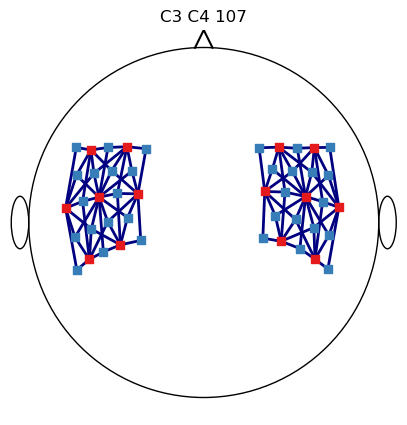

In [16]:
fig, ax = p.subplots(1, 1)

fig.set_size_inches(5, 5)

# cedalion.plots.scalp_plot(
import cedalion.vis.anatomy.scalp_plot
cedalion.vis.anatomy.scalp_plot(
    amp_reduced_c3_c4,
    geo3d,
    np.ones(amp_reduced_c3_c4.channel.size),
    ax,
    cmap="jet",
    title="C3 C4 107",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
)

In [17]:
#write_path = os.path.join(datasets_path, 'NN22_Resting_State', "NN_22_C3_C4_close_channels")
#with open(write_path, 'wb') as f:
#    pickle.dump(list(amp_reduced_c3_c4.channel.values), f)

In [18]:
T = np.array([[-9.57882715e-01, -7.20747802e-03,  6.20182970e-03,
         2.21208490e+02],
       [-2.02272565e-02,  6.03815749e-02,  9.94046199e-01,
        -2.03009885e+01],
       [-8.79480361e-03, -1.02761995e+00,  6.59200035e-02,
         2.87749129e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
geo3d_aligned = geo3d.points.apply_transform(T)

In [19]:
geo3d_aligned[geo3d_aligned.type != cdc.PointType.LANDMARK]

Magnitude,[[295.77957634055707 5.254180621421629 273.84732623764694] [280.7053432596287 38.38943604068645 270.2035523178219] [303.1554336051107 -10.697200367180248 305.61078623091413] [297.12359506512297 27.64080278750144 303.20352820020736] [275.3463549808336 58.394153562740854 303.8088112361245] [300.4512073078652 10.508757317597865 338.7472530894982] [288.1749193496734 45.39754053163867 337.59287995447585] [147.52933111468565 4.9387626432343374 271.0951405411938] [164.05776827658033 38.820180186138785 269.5520506296732] [139.74478847000324 -9.847349768176286 304.80119994419584] [147.38426149192952 28.309634794137057 302.3050795278105] [172.36468150567308 59.52943850953531 301.80246429409726] [143.80903529763287 10.751520167145834 338.6549751771559] [159.54272604279436 48.057479164891916 335.48162766207935] [297.1151829993346 -13.97747165649448 273.5218807544238] [290.28635832381286 22.39139073818013 271.3937164764413] [268.70501357957767 52.839263633837746 271.05075326616446] [300.0736306667766 -2.8143121988294766 288.7302723490721] [296.9332122099688 17.041869629038164 288.0409840278761] [289.9820552487337 33.98622493624649 286.66447526376277] [278.44040815926223 49.82917274121239 287.32547291719476] [301.4548316482771 9.545553904184906 304.12379676801834] [288.25832211513574 43.85144512327258 302.2532096667558] [303.4321626204769 -0.7022802096143614 322.8375968796723] [301.25188868455734 20.387249150138917 322.0543658550043] [295.07907895994697 38.09710598078422 320.33979114807784] [283.30837543865096 53.80299449955237 319.86185269987624] [301.2339032830283 -8.550369406609617 339.50253774941785] [296.6672881759865 28.32448879764016 338.5489565175777] [274.7617851283306 60.54559569243922 337.5759685830806] [145.14252903793442 -14.10133394894977 272.1499417888594] [153.94781147834658 23.22624533677452 270.77766011269733] [177.11054217168976 53.08597056199599 269.5860137883967] [142.7313789744419 -1.9991916992657401 287.9798754907969] [146.68128477637885 16.699366336715894 286.4279085317937] [155.34602121693067 35.22577793445802 286.42416040769643] [167.70643367030652 50.259076389137945 285.3416074213509] [141.92798704805944 9.682246919224834 303.69199580256094] [158.71592853431065 45.64384688214484 300.9647884560844] [140.21708775538696 0.7351815504945911 321.805645071857] [142.8896007055431 20.169860849272336 320.83839156983197] [150.94998598180652 39.36108402201734 318.7133755237963] [164.03872281719185 54.80931387742295 318.3698431372062] [142.37443841579312 -8.440600823021741 339.0353315725638] [148.9266702452589 30.265043368595894 336.6240521344469] [172.41694204618602 61.191513851123176 335.8736445722839]]
Units,millimeter


In [20]:
geo3d_snapped

Magnitude,[[22.305188 148.640931 173.95324] [37.017287 153.0637 205.374637] [14.210651 115.535393 159.052266] [20.969298 122.023178 196.119996] [43.548383 118.282965 228.177213] [17.672831 86.691375 179.974919] [29.784641 86.802385 214.220386] [172.14753 146.021772 178.391734] [154.144141 151.620439 210.483398] [179.944423 114.774904 165.891021] [171.252561 118.219913 202.9062] [145.795619 120.988747 231.438654] [175.152794 84.079357 186.930163] [160.409495 85.211082 219.237429] [21.11732 148.228098 153.629754] [27.284997 148.011314 191.66047] [48.650865 150.837002 220.250804] [17.444384 130.754712 166.98206] [20.248632 134.343796 182.809407] [26.951883 132.400389 202.613688] [38.55726 135.673378 217.238129] [16.020709 116.709453 178.069628] [30.255657 122.995275 212.870067] [15.079748 98.83146 168.893058] [17.143988 102.563634 189.084949] [22.323223 104.083596 205.239349] [33.450546 103.736713 221.793486] [16.84611 84.454605 158.721535] [22.127989 86.557756 199.127269] [44.992658 87.008575 230.790184] [174.449214 145.185906 158.475497] [166.158204 148.833551 193.448759] [143.31158 149.606212 222.611391] [177.094379 129.889836 169.749978] [172.864609 133.291567 189.122872] [162.758218 135.223818 208.190639] [153.054209 135.925568 219.575379] [177.758222 117.901526 182.129191] [161.665187 118.219836 217.498688] [179.224602 99.115222 176.711905] [176.24381 97.784925 193.873899] [168.69686 102.828954 211.916669] [156.20626 104.453031 225.886693] [176.035806 80.49298 168.259878] [170.442641 87.84617 204.86386] [146.374285 89.324479 233.569868]]
Units,millimeter


In [21]:
amp

Magnitude,[[[0.34431705 0.34532916 0.34454263 ... 0.35054689 0.35046341000000003 0.35101944] [0.5904892700000001 0.59262302 0.58912712 ... 0.62210679 0.62157569 0.6222100700000001]] [[0.16048748000000002 0.16097733 0.16041867 ... 0.16523496 0.16514778 0.16561836] [0.28459895 0.28550005 0.28358962 ... 0.29509981 0.29464741 0.2952339]] [[0.22655664 0.22709865 0.22617029 ... 0.23120753 0.23131024 0.23175133] [0.38428362 0.38532995999999997 0.38270145 ... 0.40610419 0.40577051999999997 0.40631262]] ... [[0.27706577 0.27491078 0.27440736 ... 0.28216082 0.2826712 0.28265213] [0.6214316299999999 0.61495523 0.61320716 ... 0.638672 0.63974443 0.6402925]] [[0.0672463 0.06711555 0.06732178999999999 ... 0.05128456 0.05118164 0.05146013] [0.20534368 0.20462466 0.20506163 ... 0.16418918999999998 0.16392307 0.16483712]] [[0.08737794 0.08668805 0.08650405 ... 0.08887398 0.08911863 0.08913724] [0.21327398 0.21070601 0.21005826 ... 0.22037825 0.22085755999999998 0.22107664999999999]]]
Units,dimensionless


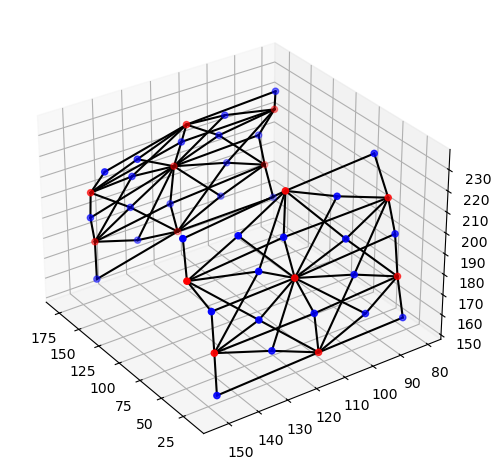

In [22]:
cedalion.vis.anatomy.plot_montage3D(amp, geo3d_snapped)

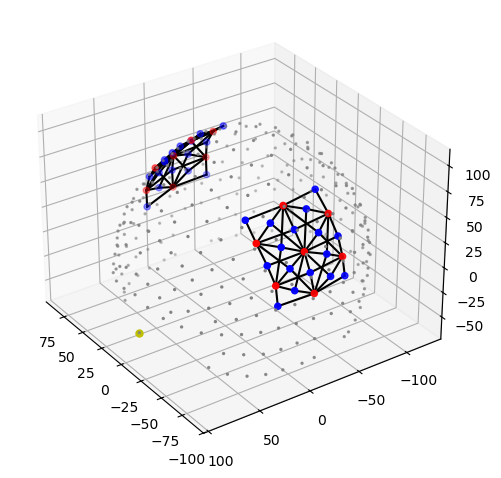

In [23]:
cedalion.vis.anatomy.plot_montage3D(amp, geo3d)

In [24]:
dists = cedalion.xrutils.norm(geo3d.loc[amp.source] - geo3d.loc[amp.detector], dim=geo3d.points.crs)

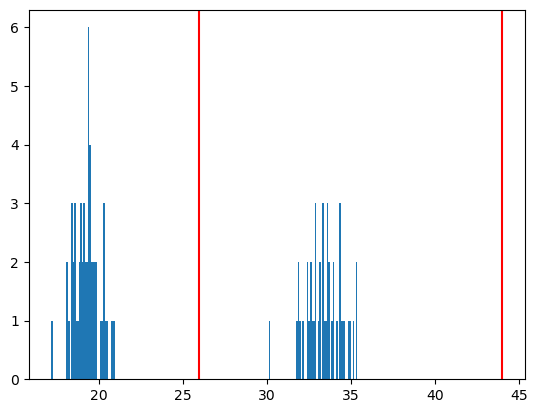

In [25]:
p.hist(dists, bins=200)
p.axvline(26, color='red')
p.axvline(44, color='red')
p.show()

In [26]:
selected_channels = list(dists.channel[dists.values < 44].values)
len(selected_channels)

100

In [27]:
#write_path = os.path.join(datasets_path, 'BS_Laura', "BS_Laura_less_than_4cm_chans")
#with open(write_path, 'wb') as f:
#    pickle.dump(selected_channels, f)

In [28]:
amp = amp.sel(channel=selected_channels)
#amp = amp_reduced_c3_c4

In [29]:
#dists = cedalion.xrutils.norm(geo3d_snapped.loc[amp.source] - geo3d_snapped.loc[amp.detector], dim=geo3d_snapped.points.crs)
ts_long, ts_short = cedalion.nirs.split_long_short_channels(
    amp, rec.geo3d, distance_threshold=distance_threshold
)

In [30]:
len(list(ts_long.channel.values))

44

In [31]:
# write_path = os.path.join(datasets_path, 'BS_Laura', "long_channels")
write_path = os.path.join(results_path_prefix, "long_channels.pkl")
os.makedirs(os.path.dirname(write_path), exist_ok=True)
with open(write_path, 'wb') as f:
    pickle.dump(list(ts_long.channel.values), f)

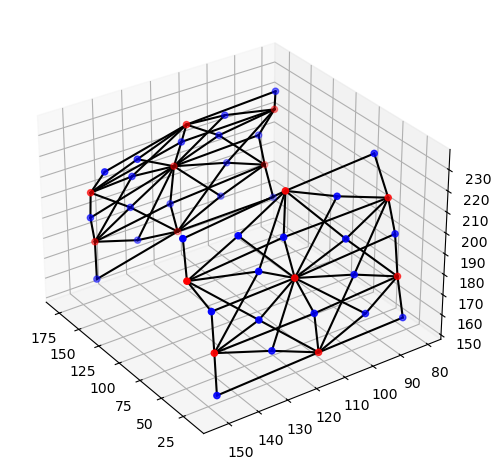

In [32]:
# cedalion.plots.plot_montage3D(amp, geo3d_snapped)
cedalion.vis.anatomy.plot_montage3D(amp, geo3d_snapped)

In [33]:
plt = pv.Plotter()
#cedalion.plots.plot_surface(plt, head.brain, color="w")
# cedalion.plots.plot_surface(plt, head.brain)
cedalion.vis.blocks.plot_surface(plt, head.brain)
# cedalion.plots.plot_labeled_points(plt, geo3d_snapped, show_labels=True)
cedalion.vis.blocks.plot_labeled_points(plt, geo3d_snapped, show_labels=True)
# save fig as pdf and svg
#if save_plot:
#    plt.show()
#    plt.save_graphic(os.path.join(base_path, "probe.pdf"))
#    plt.save_graphic(os.path.join(base_path, "probe.svg"))
#else:
plt.show()

Widget(value='<iframe src="http://localhost:34489/index.html?ui=P_0x7f38b6e2c550_0&reconnect=auto" class="pyvi…

In [34]:
c4_dets = ['D111', 'D110', 'D112']
c3_dets = ['D28', 'D31', 'D19']

inner_outer_sources = [47, 46, 52, 54, 56, 53, 50, 38, 44, ]
# 52



In [35]:
def generate_detector_names(detector_numbers):
    return [f'D{num}' for num in detector_numbers]

def generate_source_names(source_numbers):
    return [f'S{num}' for num in source_numbers]

def generate_removed_optodes(optode_numbers):
    removed = []
    i = 0
    toggle = True  # Start with removing
    while i < len(optode_numbers):
        if toggle:
            removed.extend(optode_numbers[i:i+2])  # remove two
        # else: keep two (skip)
        i += 2
        toggle = not toggle
    return generate_detector_names(removed)

In [36]:
if data_type == 'HD_Squeezing' or data_type == 'BallSqueezingHD_modified':
    #optodes_to_remove_0 = ['D21','D22','D27','D28','D5','D6','D11','D12']
    #optodes_to_remove_1 = optodes_to_remove_0 + ['D20','D23','D26','D29', 'D4','D7','D10','D13'] 
    #optodes_to_remove_2 = optodes_to_remove_1 + ['S2', 'D9', 'S7', 'S1', 'D8', 'S6', 'S14', 'D25', 'S9', 'S13', 'D24', 'S8']
    optodes_to_remove_0 = ['D20','D23','D26','D29','D4','D7','D10','D13']
    optodes_to_remove_1 = optodes_to_remove_0 + ['D21','D22','D27','D28','D5','D6','D11','D12']#, 'D32', 'D16']#, 'S5', 'D3', 'S12', 'D19']
    optodes_to_remove_2 = optodes_to_remove_1 + ['S10', 'S11', 'S12', 'D17', 'D18', 'D19', 'D30', 'D31', 'D32', 'D1', 'D2', 'D3', 'S3', 'S4', 'S5', 'D14', 'D15', 'D16']
if data_type == 'Stroop_J':
    optodes_to_remove_0 = ['D11','D13', 'D15', 'D17', 'D18', 'D20', 'D22', 'D24', 'D35','D37', 'D39', 'D41', 'D42', 'D44', 'D46', 'D48']
    optodes_to_remove_1 = ['D11','D12', 'D15', 'D16', 'D19', 'D20', 'D23', 'D24', 'D35','D36', 'D39', 'D40', 'D43', 'D44', 'D47', 'D48'] + ['D10', 'D13', 'D14', 'D17', 'D18', 'D21', 'D22', 'D25','D34', 'D37', 'D38', 'D41', 'D42', 'D45', 'D46', 'D49']
    optodes_to_remove_2 = optodes_to_remove_1 + ['S1', 'D26', 'S18', 'S2', 'D27', 'S19', 'S3', 'D28', 'S20', 'S4', 'D29', 'S21', 'S5', 'D30', 'S22', 'S6', 'D31', 'S23', 'S7', 'D32', 'S24', 'S8', 'D33', 'S25'] 
if data_type == 'Stroop_D':
    optodes_to_remove_0 = ['D11','D13', 'D15', 'D17', 'D18', 'D20', 'D22', 'D24', 'D35','D37', 'D39', 'D41', 'D42', 'D44', 'D46', 'D48']
    optodes_to_remove_1 = ['D11','D12', 'D15', 'D16', 'D19', 'D20', 'D23', 'D24', 'D35','D36', 'D39', 'D40', 'D43', 'D44', 'D47', 'D48'] + ['D10', 'D13', 'D14', 'D17', 'D18', 'D21', 'D22', 'D25','D34', 'D37', 'D38', 'D41', 'D42', 'D45', 'D46', 'D49']
    optodes_to_remove_2 = optodes_to_remove_1 + ['S1', 'D26', 'S18', 'S2', 'D27', 'S19', 'S3', 'D28', 'S20', 'S4', 'D29', 'S21', 'S5', 'D30', 'S22', 'S6', 'D31', 'S23', 'S7', 'D32', 'S24', 'S8', 'D33', 'S25'] 
if data_type.startswith('Syn') or data_type == 'BS_Laura':
    detector_numbers_rim = [50, 51, 53, 54, 55, 113, 116, 117, 119, 120, 75 ,76, 78, 79, 98, 99, 101, 102, 81, 82, 84, 85, 88, 89, 91, 92, 95, 96, 138, 139, 142, 143, 33, 34, 37, 38, 40, 65, 68, 69, 71, 72, 3, 4, 6, 7, 10, 11, 13, 14, 41, 42, 44, 45, 48, 57, 59, 60, 63, 64]
    detector_numbers_center_outer_3 = [126, 127, 128, 111, 112, 136, 135, 134, 130, 17, 18, 19, 28, 27, 121]
    indices_outer_3 = [0, 2, 4, 6, 9, 11, 13]
    indices_outer_3_v2 = [0, 2, 4, 6, 9, 11, 13]
    detector_numbers_center_outer_2 = [125, 110, 133, 129, 20, 31, 26]
    detector_numbers_center_outer_1 = [124, 109, 108, 107, 132, 131, 21, 22, 23, 30, 29, 123]
    indices_outer_2 = [1, 3, 5]
    #indices_outer_2 = [0, 2, 4, 6]
    indices_outer_1_subset_1 = [1, 3, 5, 6, 8, 10]
    indices_outer_1_subset_2 = [0, 1, 3, 5, 6, 8, 10, 11]
    detector_numbers_center = [24, 32, 122, 106, 105]
    detector_numbers_wo_central = [24, 32, 106, 105]
    outer_ring_sources = [42, 41, 24, 23, 16, 15, 14, 2, 1, 32, 31, 30, 35, 34, 33]
    outer_ring_second_sources = [45, 18, 19, 17, 11, 10, 9, 8, 7, 6, 26, 25, 40, 39, 38]
    outer_ring_detectors = [56, 118, 77, 100, 83, 90, 137, 144, 39, 70, 5, 12, 43, 58, 49]
    inner_outer_sources = [52, 46, 47, 50, 53, 56, 54]
    inner_outer_sources_selected = [52, 47, 53]

    source_numbers_center = [49, 48, 55, 51]
    source_numbers_center_outer_1 = [47, 46, 52, 54, 56, 53, 50]
    # + generate_detector_names([detector_numbers_center_outer_3[i] for i in indices_outer_3])
    optodes_to_remove_0 = generate_removed_optodes(detector_numbers_rim) + generate_detector_names([detector_numbers_center_outer_2[i] for i in indices_outer_2]) + generate_detector_names(detector_numbers_wo_central)
    optodes_to_remove_1 = generate_detector_names(detector_numbers_rim) + generate_detector_names([detector_numbers_center_outer_3[i] for i in indices_outer_3]) + generate_detector_names(detector_numbers_center_outer_2) + generate_detector_names([detector_numbers_center_outer_1[i] for i in indices_outer_1_subset_1]) + generate_detector_names(detector_numbers_wo_central) # + generate_source_names(inner_outer_sources_selected)
    optodes_to_remove_2 = generate_detector_names(detector_numbers_rim) + generate_detector_names(outer_ring_detectors) + generate_source_names(outer_ring_sources) + generate_source_names(outer_ring_second_sources) + generate_detector_names(detector_numbers_center_outer_3) + generate_detector_names(detector_numbers_center_outer_2) + generate_detector_names([detector_numbers_center_outer_1[i] for i in indices_outer_1_subset_2]) + generate_detector_names(detector_numbers_wo_central) # + generate_source_names(inner_outer_sources_selected)


In [37]:
geo3d_snapped

Magnitude,[[22.305188 148.640931 173.95324] [37.017287 153.0637 205.374637] [14.210651 115.535393 159.052266] [20.969298 122.023178 196.119996] [43.548383 118.282965 228.177213] [17.672831 86.691375 179.974919] [29.784641 86.802385 214.220386] [172.14753 146.021772 178.391734] [154.144141 151.620439 210.483398] [179.944423 114.774904 165.891021] [171.252561 118.219913 202.9062] [145.795619 120.988747 231.438654] [175.152794 84.079357 186.930163] [160.409495 85.211082 219.237429] [21.11732 148.228098 153.629754] [27.284997 148.011314 191.66047] [48.650865 150.837002 220.250804] [17.444384 130.754712 166.98206] [20.248632 134.343796 182.809407] [26.951883 132.400389 202.613688] [38.55726 135.673378 217.238129] [16.020709 116.709453 178.069628] [30.255657 122.995275 212.870067] [15.079748 98.83146 168.893058] [17.143988 102.563634 189.084949] [22.323223 104.083596 205.239349] [33.450546 103.736713 221.793486] [16.84611 84.454605 158.721535] [22.127989 86.557756 199.127269] [44.992658 87.008575 230.790184] [174.449214 145.185906 158.475497] [166.158204 148.833551 193.448759] [143.31158 149.606212 222.611391] [177.094379 129.889836 169.749978] [172.864609 133.291567 189.122872] [162.758218 135.223818 208.190639] [153.054209 135.925568 219.575379] [177.758222 117.901526 182.129191] [161.665187 118.219836 217.498688] [179.224602 99.115222 176.711905] [176.24381 97.784925 193.873899] [168.69686 102.828954 211.916669] [156.20626 104.453031 225.886693] [176.035806 80.49298 168.259878] [170.442641 87.84617 204.86386] [146.374285 89.324479 233.569868]]
Units,millimeter


In [38]:
# print total number of optodes 
print("Total number of optodes:", len(set(amp.source.values) | set(amp.detector.values)))
print("Total number of channels:", len(amp.channel.values))
print("Total number of long channels:", len(ts_long.channel.values))
print("")

mask = ~amp.source.isin(optodes_to_remove_0) & ~amp.detector.isin(optodes_to_remove_0)
amp_reduced_0 = amp.sel(channel=mask)
ts_long_reduced_0, ts_short_reduced_0 = cedalion.nirs.split_long_short_channels(
    amp_reduced_0, geo3d, distance_threshold=distance_threshold
)

percentage_optodes_subset_1 = (len(set(amp_reduced_0.source.values) | set(amp_reduced_0.detector.values)) / len(set(amp.source.values) | set(amp.detector.values))) * 100
percentage_channels_subset_1 = (len(amp_reduced_0.channel.values) / len(amp.channel.values)) * 100
percentage_long_channels_subset_1 = (len(ts_long_reduced_0.channel.values) / len(ts_long.channel.values)) * 100
print("Total number of optodes subset 1: " + str(len(set(amp_reduced_0.source.values) | set(amp_reduced_0.detector.values))) + " (" + str(round(percentage_optodes_subset_1, 2)) + "%)")
print("Total number of channels subset 1: " + str(len(amp_reduced_0.channel.values)) + " (" + str(round(percentage_channels_subset_1, 2)) + "%)")
print("Total number of long channels subset 1: " + str(len(ts_long_reduced_0.channel.values)) + " (" + str(round(percentage_long_channels_subset_1, 2)) + "%)")
print("")

mask = ~amp.source.isin(optodes_to_remove_1) & ~amp.detector.isin(optodes_to_remove_1)
amp_reduced_1 = amp.sel(channel=mask)
ts_long_reduced_1, ts_short_reduced_1 = cedalion.nirs.split_long_short_channels(
    amp_reduced_1, geo3d, distance_threshold=distance_threshold
)

percentage_optodes_subset_2 = (len(set(amp_reduced_1.source.values) | set(amp_reduced_1.detector.values)) / len(set(amp.source.values) | set(amp.detector.values))) * 100
percentage_channels_subset_2 = (len(amp_reduced_1.channel.values) / len(amp.channel.values)) * 100
percentage_long_channels_subset_2 = (len(ts_long_reduced_1.channel.values) / len(ts_long.channel.values)) * 100
print("Total number of optodes subset 2: " + str(len(set(amp_reduced_1.source.values) | set(amp_reduced_1.detector.values))) + " (" + str(round(percentage_optodes_subset_2, 2)) + "%)")
print("Total number of channels subset 2: " + str(len(amp_reduced_1.channel.values)) + " (" + str(round(percentage_channels_subset_2, 2)) + "%)")
print("Total number of long channels subset 2: " + str(len(ts_long_reduced_1.channel.values)) + " (" + str(round(percentage_long_channels_subset_2, 2)) + "%)")
print("")

mask = ~amp.source.isin(optodes_to_remove_2) & ~amp.detector.isin(optodes_to_remove_2)
amp_reduced_2 = amp.sel(channel=mask)
ts_long_reduced_2, ts_short_reduced_2 = cedalion.nirs.split_long_short_channels(
    amp_reduced_2, geo3d, distance_threshold=distance_threshold
)

percentage_optodes_subset_3 = (len(set(amp_reduced_2.source.values) | set(amp_reduced_2.detector.values)) / len(set(amp.source.values) | set(amp.detector.values))) * 100
percentage_channels_subset_3 = (len(amp_reduced_2.channel.values) / len(amp.channel.values)) * 100
percentage_long_channels_subset_3 = (len(ts_long_reduced_2.channel.values) / len(ts_long.channel.values)) * 100
print("Total number of optodes subset 3: " + str(len(set(amp_reduced_2.source.values) | set(amp_reduced_2.detector.values))) + " (" + str(round(percentage_optodes_subset_3, 2)) + "%)")
print("Total number of channels subset 3: " + str(len(amp_reduced_2.channel.values)) + " (" + str(round(percentage_channels_subset_3, 2)) + "%)")
print("Total number of long channels subset 3: " + str(len(ts_long_reduced_2.channel.values)) + " (" + str(round(percentage_long_channels_subset_3, 2)) + "%)")
print("")

Total number of optodes: 46
Total number of channels: 100
Total number of long channels: 44

Total number of optodes subset 1: 38 (82.61%)
Total number of channels subset 1: 76 (76.0%)
Total number of long channels subset 1: 36 (81.82%)

Total number of optodes subset 2: 30 (65.22%)
Total number of channels subset 2: 44 (44.0%)
Total number of long channels subset 2: 20 (45.45%)

Total number of optodes subset 3: 12 (26.09%)
Total number of channels subset 3: 8 (8.0%)
Total number of long channels subset 3: 8 (18.18%)



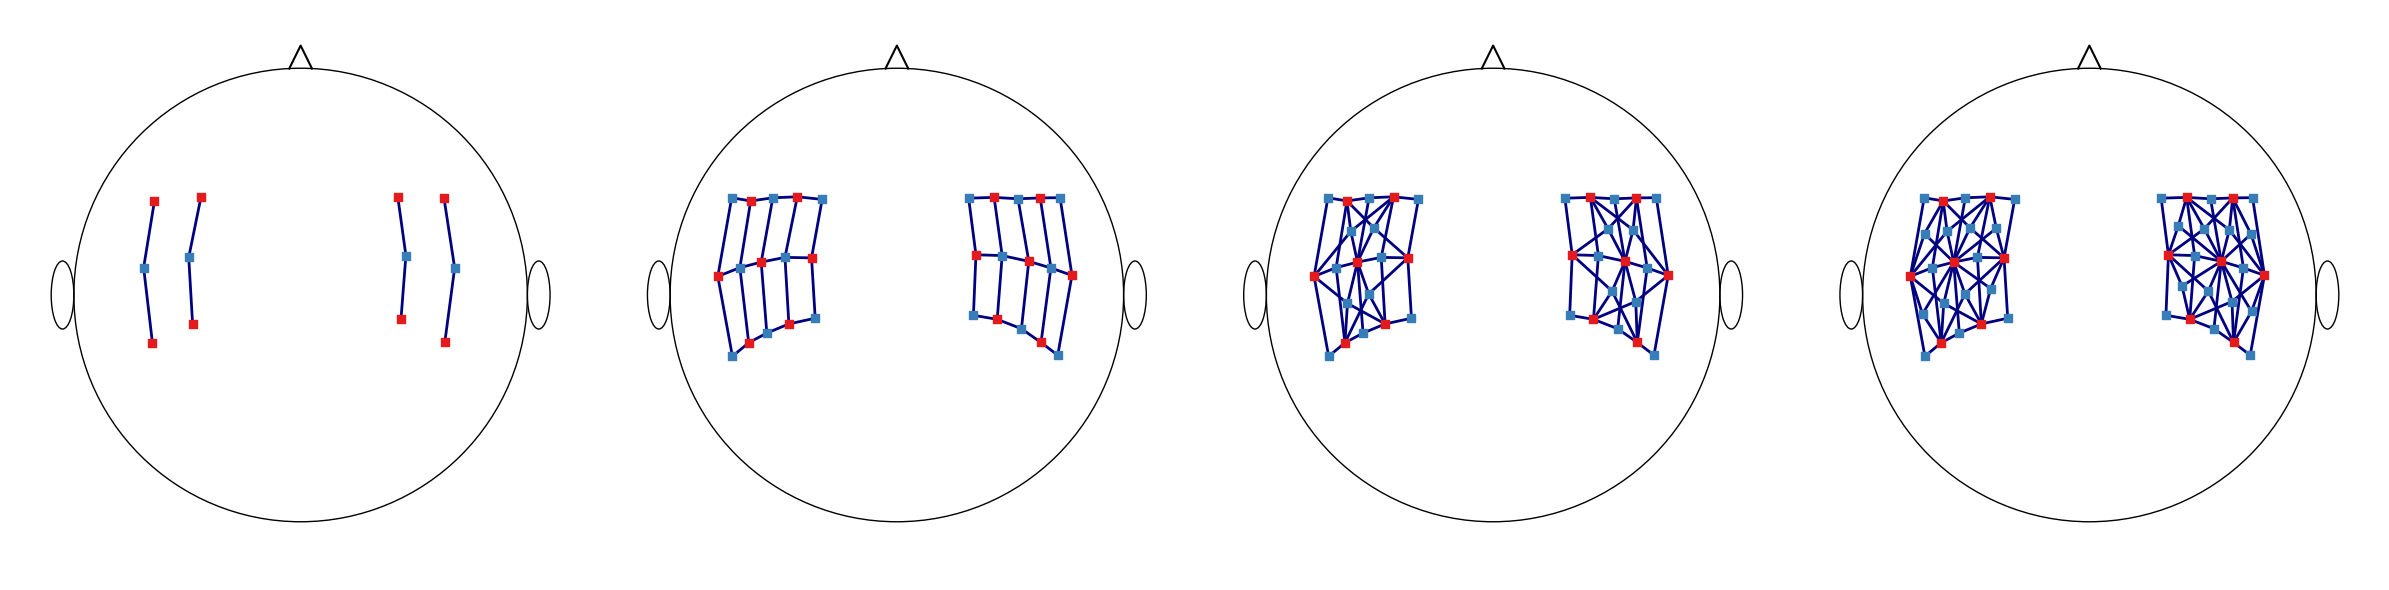

In [39]:
fig, ax = p.subplots(1, 4)
# adjust plot size
fig.set_size_inches(24, 6)
# cedalion.plots.scalp_plot(
cedalion.vis.anatomy.scalp_plot(
    amp_reduced_2,
    geo3d,
    np.ones(amp_reduced_2.channel.size),
    ax[0],
    cmap="jet",
    title="",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
    optode_labels=False
)
# cedalion.plots.scalp_plot(
cedalion.vis.anatomy.scalp_plot(
    amp_reduced_1,
    geo3d,
    np.ones(amp_reduced_1.channel.size),
    ax[1],
    cmap="jet",
    title="",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
)
# cedalion.plots.scalp_plot(
cedalion.vis.anatomy.scalp_plot(
    amp_reduced_0,
    geo3d,
    np.ones(amp_reduced_0.channel.size),
    ax[2],
    cmap="jet",
    title="",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
)
# cedalion.plots.scalp_plot(
cedalion.vis.anatomy.scalp_plot(
    amp,
    geo3d,
    np.ones(amp.channel.size),
    ax[3],
    cmap="jet",
    title="",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
)
p.tight_layout()

# chan_subsets_img_path = configs.images_path_prefix + 'channel_subsets/'
chan_subsets_img_path = results_path_prefix + 'channel_subsets/'
os.makedirs(os.path.join(chan_subsets_img_path, data_type), exist_ok=True)
p.savefig(os.path.join(chan_subsets_img_path, data_type, "subsets_only_all_no_titles.png"))
p.savefig(os.path.join(chan_subsets_img_path, data_type, "subsets_only_all_no_titles.pdf"))
p.savefig(os.path.join(chan_subsets_img_path, data_type, "subsets_only_all_no_titles.svg"))
p.show()

In [40]:
subsets_data = {}

# Full set
subsets_data["full"] = {}
subsets_data["full"]["n_optodes"] = len(set(amp.source.values) | set(amp.detector.values))
subsets_data["full"]["n_optodes_percent"] = 100.0
subsets_data["full"]["all"] = list(amp.channel.values)
subsets_data["full"]["all_percent"] = 100.0
subsets_data["full"]["long"] = list(ts_long.channel.values)
subsets_data["full"]["long_percent"] = 100.0
subsets_data["full"]["short"] = list(ts_short.channel.values)

# Subset 1
subsets_data["subset_1"] = {}
subsets_data["subset_1"]["n_optodes"] = len(set(amp_reduced_0.source.values) | set(amp_reduced_0.detector.values))
subsets_data["subset_1"]["n_optodes_percent"] = round(percentage_optodes_subset_1, 2)
subsets_data["subset_1"]["all"] = list(amp_reduced_0.channel.values)
subsets_data["subset_1"]["all_percent"] = round(percentage_channels_subset_1, 2)
subsets_data["subset_1"]["long"] = list(ts_long_reduced_0.channel.values)
subsets_data["subset_1"]["long_percent"] = round(percentage_long_channels_subset_1, 2)
subsets_data["subset_1"]["short"] = list(ts_short_reduced_0.channel.values)

# Subset 2
subsets_data["subset_2"] = {}
subsets_data["subset_2"]["n_optodes"] = len(set(amp_reduced_1.source.values) | set(amp_reduced_1.detector.values))
subsets_data["subset_2"]["n_optodes_percent"] = round(percentage_optodes_subset_2, 2)
subsets_data["subset_2"]["all"] = list(amp_reduced_1.channel.values)
subsets_data["subset_2"]["all_percent"] = round(percentage_channels_subset_2, 2)
subsets_data["subset_2"]["long"] = list(ts_long_reduced_1.channel.values)
subsets_data["subset_2"]["long_percent"] = round(percentage_long_channels_subset_2, 2)
subsets_data["subset_2"]["short"] = list(ts_short_reduced_1.channel.values)

# Subset 3
subsets_data["subset_3"] = {}
subsets_data["subset_3"]["n_optodes"] = len(set(amp_reduced_2.source.values) | set(amp_reduced_2.detector.values))
subsets_data["subset_3"]["n_optodes_percent"] = round(percentage_optodes_subset_3, 2)
subsets_data["subset_3"]["all"] = list(amp_reduced_2.channel.values)
subsets_data["subset_3"]["all_percent"] = round(percentage_channels_subset_3, 2)
subsets_data["subset_3"]["long"] = list(ts_long_reduced_2.channel.values)
subsets_data["subset_3"]["long_percent"] = round(percentage_long_channels_subset_3, 2)
subsets_data["subset_3"]["short"] = list(ts_short_reduced_2.channel.values)

In [41]:
subsets_data["full"]

{'n_optodes': 46,
 'n_optodes_percent': 100.0,
 'all': ['S1D1',
  'S1D2',
  'S1D4',
  'S1D5',
  'S1D6',
  'S1D8',
  'S2D2',
  'S2D3',
  'S2D5',
  'S2D6',
  'S2D7',
  'S2D9',
  'S3D1',
  'S3D4',
  'S3D5',
  'S3D8',
  'S3D10',
  'S3D11',
  'S3D14',
  'S4D2',
  'S4D4',
  'S4D5',
  'S4D6',
  'S4D7',
  'S4D8',
  'S4D9',
  'S4D10',
  'S4D11',
  'S4D12',
  'S4D13',
  'S4D15',
  'S5D3',
  'S5D6',
  'S5D7',
  'S5D9',
  'S5D12',
  'S5D13',
  'S5D16',
  'S6D8',
  'S6D10',
  'S6D11',
  'S6D12',
  'S6D14',
  'S6D15',
  'S7D9',
  'S7D11',
  'S7D12',
  'S7D13',
  'S7D15',
  'S7D16',
  'S8D17',
  'S8D18',
  'S8D20',
  'S8D21',
  'S8D22',
  'S8D24',
  'S9D18',
  'S9D19',
  'S9D21',
  'S9D22',
  'S9D23',
  'S9D25',
  'S10D17',
  'S10D20',
  'S10D21',
  'S10D24',
  'S10D26',
  'S10D27',
  'S10D30',
  'S11D18',
  'S11D20',
  'S11D21',
  'S11D22',
  'S11D23',
  'S11D24',
  'S11D25',
  'S11D26',
  'S11D27',
  'S11D28',
  'S11D29',
  'S11D31',
  'S12D19',
  'S12D22',
  'S12D23',
  'S12D25',
  'S12D28',
  'S1

In [42]:
# if data_type == 'HD_Squeezing' or data_type == 'BallSqueezingHD_modified':
#     suffix = data_type
# if data_type == 'Stroop_J':
#     suffix = 'Stroop_Jessie'
# if data_type == 'Stroop_D':
#     suffix = 'Stroop_Deja'
# if data_type.startswith('Syn'):
#     suffix = 'NN22_Resting_State'
# if data_type == 'BS_Laura':
#     suffix = 'BS_Laura'

# write_path = os.path.join(datasets_path, suffix, "subsets_data")

In [43]:
# write_path

In [44]:
# save subset_data as pickle file
write_path = os.path.join(results_path_prefix, "subsets_data.pkl")
os.makedirs(os.path.dirname(write_path), exist_ok=True)
with open(write_path, 'wb') as f:
    pickle.dump(subsets_data, f)
print("wrote subset data to ", write_path)

wrote subset data to  results/subset/BallSqueezingHD_modified/subsets_data.pkl


In [45]:
print(subsets_data.keys())
print(subsets_data['subset_2'].keys())
print(len(subsets_data['subset_2']['short']))
print(len(subsets_data['subset_2']['long']))
print(len(subsets_data['full']['short']))
subsets_data['subset_2']['n_optodes']
subsets_data['subset_2']['long_percent']
subsets_data['full']['long_percent']

dict_keys(['full', 'subset_1', 'subset_2', 'subset_3'])
dict_keys(['n_optodes', 'n_optodes_percent', 'all', 'all_percent', 'long', 'long_percent', 'short'])
24
20
56


100.0

In [46]:
# import pickle

# with open("datasets/raw/BallSqueezingHD_modified/subsets_data", "rb") as f:
#     subsets = pickle.load(f)

# keep_all = subsets["subset_1"]["all"]
# keep_long = subsets["subset_1"]["long"]

# amp_subset = rec["amp"].sel(channel=keep_all)
# amp_long = rec["amp"].sel(channel=keep_long)
